# TMDB Box Office Prediction - Data Mining Final Project

## Introduction

Bringing in more than 40 billion dollars every year, the movie industry is one the biggest market movers reaching the global population.  And if one bothered to look at the credits at the end of a movie, we can see the shear volume of individuals that are invoved in making a movie. making a movie takes a considerable amount of resources and requires a lot of upfront investment with out guarantee of success (making profit in this case)

And hence there is an absolute need for stakeholders to look back at the history of the public's reception to different sorts of movies and make a prediction on how well a preconcieved movie will perform. This need is what is behind this competetion, to make a prediction as how a movie would perform (if it is bound to be profitable or not).

In [1]:
from sklearn.linear_model import LinearRegression
from sklearn import datasets, linear_model
from sklearn.linear_model import Ridge
from sklearn.metrics import r2_score
import numpy as np
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve as roc
from sklearn.metrics import auc
from sklearn.metrics import mean_squared_error

from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, KFold

from keras.regularizers import l1
from sklearn.preprocessing import StandardScaler
from sklearn import model_selection
from sklearn.ensemble import RandomForestRegressor

import json
import ast
import eli5
import shap
import lightgbm as lgb
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

from PIL import Image
from urllib.request import urlopen
from sklearn.model_selection import train_test_split, KFold

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

from wordcloud import WordCloud, STOPWORDS

import seaborn as sns

%matplotlib inline

Using TensorFlow backend.


In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [3]:
train.loc[0, :]

id                                                                       1
belongs_to_collection    [{'id': 313576, 'name': 'Hot Tub Time Machine ...
budget                                                            14000000
genres                                      [{'id': 35, 'name': 'Comedy'}]
homepage                                                               NaN
imdb_id                                                          tt2637294
original_language                                                       en
original_title                                      Hot Tub Time Machine 2
overview                 When Lou, who has become the "father of the In...
popularity                                                         6.57539
poster_path                               /tQtWuwvMf0hCc2QR2tkolwl7c3c.jpg
production_companies     [{'name': 'Paramount Pictures', 'id': 4}, {'na...
production_countries     [{'iso_3166_1': 'US', 'name': 'United States o...
release_date             

In [4]:
train.loc[0, 'cast']

"[{'cast_id': 4, 'character': 'Lou', 'credit_id': '52fe4ee7c3a36847f82afae7', 'gender': 2, 'id': 52997, 'name': 'Rob Corddry', 'order': 0, 'profile_path': '/k2zJL0V1nEZuFT08xUdOd3ucfXz.jpg'}, {'cast_id': 5, 'character': 'Nick', 'credit_id': '52fe4ee7c3a36847f82afaeb', 'gender': 2, 'id': 64342, 'name': 'Craig Robinson', 'order': 1, 'profile_path': '/tVaRMkJXOEVhYxtnnFuhqW0Rjzz.jpg'}, {'cast_id': 6, 'character': 'Jacob', 'credit_id': '52fe4ee7c3a36847f82afaef', 'gender': 2, 'id': 54729, 'name': 'Clark Duke', 'order': 2, 'profile_path': '/oNzK0umwm5Wn0wyEbOy6TVJCSBn.jpg'}, {'cast_id': 7, 'character': 'Adam Jr.', 'credit_id': '52fe4ee7c3a36847f82afaf3', 'gender': 2, 'id': 36801, 'name': 'Adam Scott', 'order': 3, 'profile_path': '/5gb65xz8bzd42yjMAl4zwo4cvKw.jpg'}, {'cast_id': 8, 'character': 'Hot Tub Repairman', 'credit_id': '52fe4ee7c3a36847f82afaf7', 'gender': 2, 'id': 54812, 'name': 'Chevy Chase', 'order': 4, 'profile_path': '/svjpyYtPwtjvRxX9IZnOmOkhDOt.jpg'}, {'cast_id': 9, 'character

## Data
With this competeion we are given a dataset that contains a historical information of movies from the open movie database

https://www.themoviedb.org/?language=en-US

The dataset has 4K + movies and about 22 features right out of the box. the information included obvious attributes of a movie such as title, release data, genres and cast. And it also had information on it's popularity, if it belongs to a sequel or not and other features that gives us insights on how well it performed based on that data.

In [5]:
train.head()
train.columns, train.shape, test.columns, test.shape

(Index(['id', 'belongs_to_collection', 'budget', 'genres', 'homepage',
        'imdb_id', 'original_language', 'original_title', 'overview',
        'popularity', 'poster_path', 'production_companies',
        'production_countries', 'release_date', 'runtime', 'spoken_languages',
        'status', 'tagline', 'title', 'Keywords', 'cast', 'crew', 'revenue'],
       dtype='object'),
 (3000, 23),
 Index(['id', 'belongs_to_collection', 'budget', 'genres', 'homepage',
        'imdb_id', 'original_language', 'original_title', 'overview',
        'popularity', 'poster_path', 'production_companies',
        'production_countries', 'release_date', 'runtime', 'spoken_languages',
        'status', 'tagline', 'title', 'Keywords', 'cast', 'crew'],
       dtype='object'),
 (4398, 22))

## Preprocessing

We found that some of the columns had JSON data types and few had NaN values, so we started out by clearing those, to make it easy to extract the data into a dictionary. So we changed 'NaN' as '{}'.

In [6]:
#https://www.kaggle.com/artgor/eda-feature-engineering-and-model-interpretation
dict_columns = ['belongs_to_collection', 'genres', 'production_companies',
                'production_countries', 'spoken_languages', 'Keywords', 'cast', 'crew']

def text_to_dict(df):
    for column in dict_columns:
        df[column] = df[column].apply(lambda x: {} if pd.isna(x) else ast.literal_eval(x) )
    return df

train = text_to_dict(train)

test = text_to_dict(test)

In [7]:
train.columns, train.shape, test.columns, test.shape

(Index(['id', 'belongs_to_collection', 'budget', 'genres', 'homepage',
        'imdb_id', 'original_language', 'original_title', 'overview',
        'popularity', 'poster_path', 'production_companies',
        'production_countries', 'release_date', 'runtime', 'spoken_languages',
        'status', 'tagline', 'title', 'Keywords', 'cast', 'crew', 'revenue'],
       dtype='object'),
 (3000, 23),
 Index(['id', 'belongs_to_collection', 'budget', 'genres', 'homepage',
        'imdb_id', 'original_language', 'original_title', 'overview',
        'popularity', 'poster_path', 'production_companies',
        'production_countries', 'release_date', 'runtime', 'spoken_languages',
        'status', 'tagline', 'title', 'Keywords', 'cast', 'crew'],
       dtype='object'),
 (4398, 22))

In [8]:
# From kernel:  https://www.kaggle.com/gravix/gradient-in-a-box
for i, e in enumerate(train['belongs_to_collection'][:5]):
    print(i, e)

0 [{'id': 313576, 'name': 'Hot Tub Time Machine Collection', 'poster_path': '/iEhb00TGPucF0b4joM1ieyY026U.jpg', 'backdrop_path': '/noeTVcgpBiD48fDjFVic1Vz7ope.jpg'}]
1 [{'id': 107674, 'name': 'The Princess Diaries Collection', 'poster_path': '/wt5AMbxPTS4Kfjx7Fgm149qPfZl.jpg', 'backdrop_path': '/zSEtYD77pKRJlUPx34BJgUG9v1c.jpg'}]
2 {}
3 {}
4 {}


From the sampling data and measing, I assert that collection id and rest information are one to one mapping.
Check how many entries get the collection.

In [9]:
# From kernel: https://www.kaggle.com/artgor/eda-feature-engineering-and-model-interpretation
train['belongs_to_collection'].apply(lambda x: len(x) if x != {} else 0).value_counts()

0    2396
1     604
Name: belongs_to_collection, dtype: int64

In [10]:
# From kernel: https://www.kaggle.com/artgor/eda-feature-engineering-and-model-interpretation
train['collection_name'] = train['belongs_to_collection'].apply(lambda x: x[0]['name'] if x != {} else 0)
train['has_collection'] = train['belongs_to_collection'].apply(lambda x: len(x) if x != {} else 0)

test['collection_name'] = test['belongs_to_collection'].apply(lambda x: x[0]['name'] if x != {} else 0)
test['has_collection'] = test['belongs_to_collection'].apply(lambda x: len(x) if x != {} else 0)
train = train.drop('belongs_to_collection', axis = 1)
test = test.drop('belongs_to_collection', axis = 1)

Based on our domain knowledge we figured, the fact that a movie belongs to a sequel or not plays a significant role in how profitable (at least from revenue stand point) a movie is going to be. So we added a feature that just flags if a movie belongs to a collection or not. Then, we could drop the column 'belongs_to_collection'.

In [11]:
train.head()

,id,budget,genres,homepage,imdb_id,original_language,original_title,overview,popularity,poster_path,...,spoken_languages,status,tagline,title,Keywords,cast,crew,revenue,collection_name,has_collection
0,1,14000000,"[{'id': 35, 'name': 'Comedy'}]",NaN,tt2637294,en,Hot Tub Time Machine 2,"When Lou, who has become the ""father of the In...",6.575393,/tQtWuwvMf0hCc2QR2tkolwl7c3c.jpg,...,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The Laws of Space and Time are About to be Vio...,Hot Tub Time Machine 2,"[{'id': 4379, 'name': 'time travel'}, {'id': 9...","[{'cast_id': 4, 'character': 'Lou', 'credit_id...","[{'credit_id': '59ac067c92514107af02c8c8', 'de...",12314651,Hot Tub Time Machine Collection,1
1,2,40000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,tt0368933,en,The Princess Diaries 2: Royal Engagement,Mia Thermopolis is now a college graduate and ...,8.248895,/w9Z7A0GHEhIp7etpj0vyKOeU1Wx.jpg,...,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,It can take a lifetime to find true love; she'...,The Princess Diaries 2: Royal Engagement,"[{'id': 2505, 'name': 'coronation'}, {'id': 42...","[{'cast_id': 1, 'character': 'Mia Thermopolis'...","[{'credit_id': '52fe43fe9251416c7502563d', 'de...",95149435,The Princess Diaries Collection,1
2,3,3300000,"[{'id': 18, 'name': 'Drama'}]",http://sonyclassics.com/whiplash/,tt2582802,en,Whiplash,"Under the direction of a ruthless instructor, ...",64.299990,/lIv1QinFqz4dlp5U4lQ6HaiskOZ.jpg,...,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The road to greatness can take you to the edge.,Whiplash,"[{'id': 1416, 'name': 'jazz'}, {'id': 1523, 'n...","[{'cast_id': 5, 'character': 'Andrew Neimann',...","[{'credit_id': '54d5356ec3a3683ba0000039', 'de...",13092000,0,0
3,4,1200000,"[{'id': 53, 'name': 'Thriller'}, {'id': 18, 'n...",http://kahaanithefilm.com/,tt1821480,hi,Kahaani,Vidya Bagchi (Vidya Balan) arrives in Kolkata ...,3.174936,/aTXRaPrWSinhcmCrcfJK17urp3F.jpg,...,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,NaN,Kahaani,"[{'id': 10092, 'name': 'mystery'}, {'id': 1054...","[{'cast_id': 1, 'character': 'Vidya Bagchi', '...","[{'credit_id': '52fe48779251416c9108d6eb', 'de...",16000000,0,0
4,5,0,"[{'id': 28, 'name': 'Action'}, {'id': 53, 'nam...",NaN,tt1380152,ko,마린보이,Marine Boy is the story of a former national s...,1.148070,/m22s7zvkVFDU9ir56PiiqIEWFdT.jpg,...,"[{'iso_639_1': 'ko', 'name': '한국어/조선말'}]",Released,NaN,Marine Boy,{},"[{'cast_id': 3, 'character': 'Chun-soo', 'cred...","[{'credit_id': '52fe464b9251416c75073b43', 'de...",3923970,0,0


## Feature Engineering

### Genres

We started out with the genres feature, checked whether all the records had genres specified. since majority had data, we prepped the data for one hot encoding. We used word cloud for data exploration for features that have text in them. These visualizations helped us establish their importance

In [12]:
train['genres'].apply(lambda x: 1 if x != {} else 0).value_counts()

1    2993
0       7
Name: genres, dtype: int64

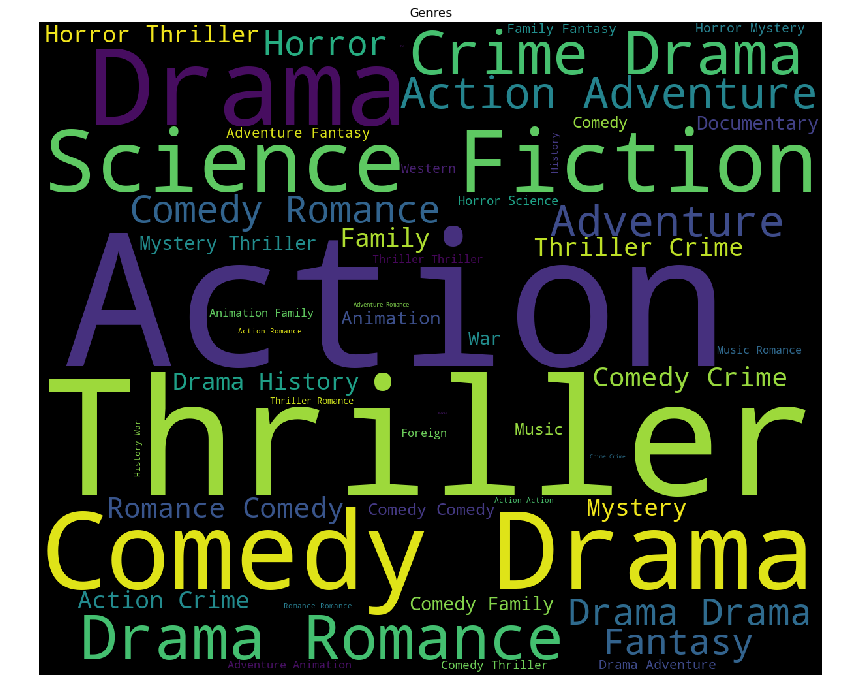

In [13]:
all_genres = list(train['genres'].apply(lambda x: [i['name'] for i in x] if x != {} else []).values)
plt.figure(figsize=(16,12))
content = ' '.join([i for j in all_genres for i in j])
wordcloud = WordCloud(width=1200, height=1000).generate(content)
plt.imshow(wordcloud)
plt.title('Genres')
plt.axis("off")
plt.show()

In [14]:
train['num_genres'] = train['genres'].apply(lambda x: len(x) if x != {} else 0)
train['all_genres'] = train['genres'].apply(lambda x: ' '.join(sorted([i['name'] for i in x])) if x != {} else '')
test['num_genres'] = test['genres'].apply(lambda x: len(x) if x != {} else 0)
test['all_genres'] = test['genres'].apply(lambda x: ' '.join(sorted([i['name'] for i in x])) if x != {} else '')

The main exploration we needed to do is to see if the genres have some influence on the revenue. or if some how it varies with it. The first thing we looked at is if the data we have actually have a decent distribution of generes. how having that number relates to the revenue.

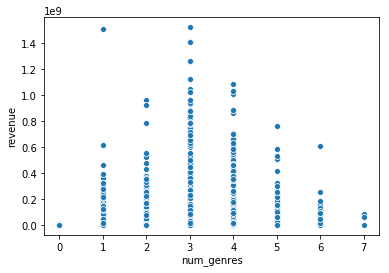

In [15]:
sns.scatterplot(x='num_genres', y='revenue', data=train)

In [16]:
list_of_genres_train = train['genres'].apply(lambda x: [i['name'] for i in x] if x != {} else []).values
set_of_genres_train = {i for j in list_of_genres_train for i in j}

list_of_genres_test = test['genres'].apply(lambda x: [i['name'] for i in x] if x != {} else []).values
set_of_genres_test = {i for j in list_of_genres_test for i in j}

all_genres = set_of_genres_train.union(set_of_genres_test)

for g in all_genres:
    train['genre_' + g] = train['all_genres'].apply(lambda x: 1 if g in x else 0)
for g in all_genres:
    test['genre_' + g] = test['all_genres'].apply(lambda x: 1 if g in x else 0)

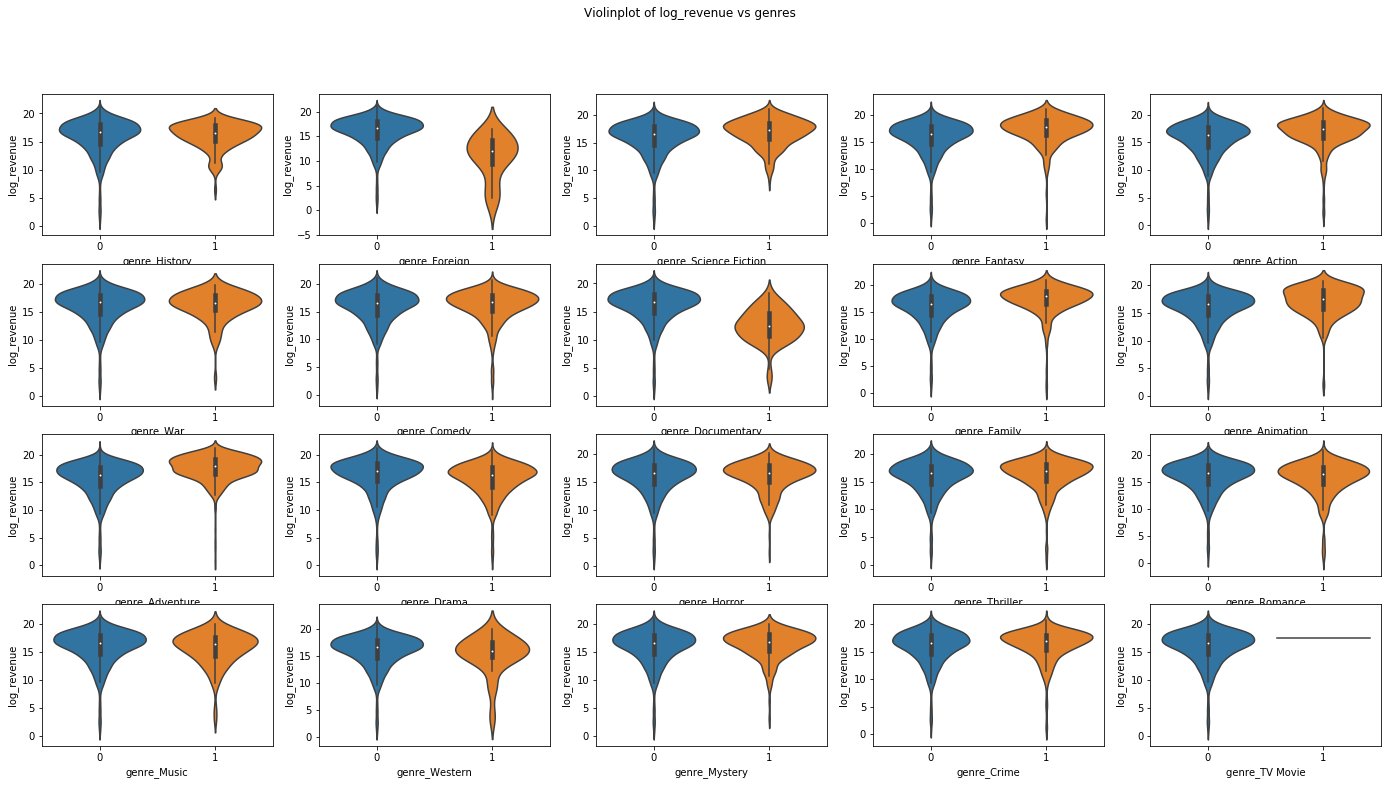

In [18]:
f, axes = plt.subplots(4, 5, figsize=(24, 12))
plt.suptitle('Violinplot of log_revenue vs genres')
for i, e in enumerate([col for col in train.columns if 'genre_' in col]):
    sns.violinplot(x=e, y='log_revenue', data=train, ax=axes[i // 5][i % 5]);

It is hard to say, which gener gets more revenue. The variance is similar, except documentary and foreign movies.

In [19]:
train = train.drop('all_genres', axis = 1)
test = test.drop('all_genres', axis = 1)
train = train.drop('genres', axis = 1)
test = test.drop('genres', axis = 1)

In [20]:
train.head()

,id,budget,homepage,imdb_id,original_language,original_title,overview,popularity,poster_path,production_companies,...,genre_Drama,genre_Horror,genre_Thriller,genre_Romance,genre_Music,genre_Western,genre_Mystery,genre_Crime,genre_TV Movie,log_revenue
0,1,14000000,NaN,tt2637294,en,Hot Tub Time Machine 2,"When Lou, who has become the ""father of the In...",6.575393,/tQtWuwvMf0hCc2QR2tkolwl7c3c.jpg,"[{'name': 'Paramount Pictures', 'id': 4}, {'na...",...,0,0,0,0,0,0,0,0,0,16.326300
1,2,40000000,NaN,tt0368933,en,The Princess Diaries 2: Royal Engagement,Mia Thermopolis is now a college graduate and ...,8.248895,/w9Z7A0GHEhIp7etpj0vyKOeU1Wx.jpg,"[{'name': 'Walt Disney Pictures', 'id': 2}]",...,1,0,0,1,0,0,0,0,0,18.370959
2,3,3300000,http://sonyclassics.com/whiplash/,tt2582802,en,Whiplash,"Under the direction of a ruthless instructor, ...",64.299990,/lIv1QinFqz4dlp5U4lQ6HaiskOZ.jpg,"[{'name': 'Bold Films', 'id': 2266}, {'name': ...",...,1,0,0,0,0,0,0,0,0,16.387512
3,4,1200000,http://kahaanithefilm.com/,tt1821480,hi,Kahaani,Vidya Bagchi (Vidya Balan) arrives in Kolkata ...,3.174936,/aTXRaPrWSinhcmCrcfJK17urp3F.jpg,{},...,1,0,1,0,0,0,0,0,0,16.588099
4,5,0,NaN,tt1380152,ko,마린보이,Marine Boy is the story of a former national s...,1.148070,/m22s7zvkVFDU9ir56PiiqIEWFdT.jpg,{},...,0,0,1,0,0,0,0,0,0,15.182615


### production companies

We applied the same approach to production companies to see data availability and used one hot encoding on it. we took the most common production companies and did the hot encoding based on that. but to keep the enfluence of the production companies intact on some level, we kept the number of production companies involved in the movie.

In [21]:
train['production_companies'].apply(lambda x: 1 if x != {} else 0).value_counts()

1    2844
0     156
Name: production_companies, dtype: int64

In [22]:
list_of_companies = list(
    train['production_companies'].apply(lambda x: [i['name'] for i in x] if x != {} else []).values)

In [23]:
train['num_companies'] = train['production_companies'].apply(lambda x: len(x) if x != {} else 0)
train['all_production_companies'] = train['production_companies'].apply(lambda x: ' '.join(sorted([i['name'] for i in x])) if x != {} else '')
top_companies = [m[0] for m in Counter([i for j in list_of_companies for i in j]).most_common(30)]
for g in top_companies:
    train['production_company_' + g] = train['all_production_companies'].apply(lambda x: 1 if g in x else 0)
    
test['num_companies'] = test['production_companies'].apply(lambda x: len(x) if x != {} else 0)
test['all_production_companies'] = test['production_companies'].apply(lambda x: ' '.join(sorted([i['name'] for i in x])) if x != {} else '')
for g in top_companies:
    test['production_company_' + g] = test['all_production_companies'].apply(lambda x: 1 if g in x else 0)

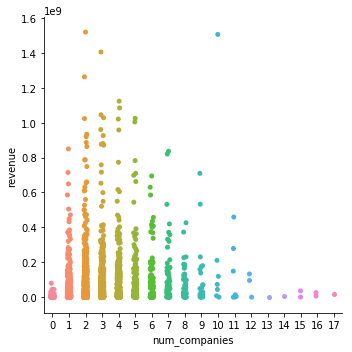

In [24]:
sns.catplot(x='num_companies', y='revenue', data=train)

### Release Date

Intuitively this feature is one of features that might impact the revenue, as the population tends to flock to the movies in certain seasons and it also quite obvioius that as the the years went the reach of the movies to the general public has increase tremendously. So we did need to do further exploration to ensure we account for it in our models.

In [25]:
test.loc[test['release_date'].isnull() == True, 'release_date'] = '01/01/98'
def fix_date(x):
    """
    Fixes dates which are in 20xx
    """
    year = x.split('/')[2]
    if int(year) <= 19:
        return x[:-2] + '20' + year
    else:
        return x[:-2] + '19' + year

train['release_date'] = train['release_date'].apply(lambda x: fix_date(x))
test['release_date'] = test['release_date'].apply(lambda x: fix_date(x))
train['release_date'] = pd.to_datetime(train['release_date'])
test['release_date'] = pd.to_datetime(test['release_date'])

def process_date(df):
    date_parts = ["year", "weekday", "month", 'weekofyear', 'day', 'quarter']
    for part in date_parts:
        part_col = 'release_date' + "_" + part
        df[part_col] = getattr(df['release_date'].dt, part).astype(int)
    
    return df

train = process_date(train)
test = process_date(test)

# train = train.drop('release_date', axis = 1)
# test = test.drop('release_date', axis = 1)

train.shape, test.shape


((3000, 83), (4398, 81))

In [26]:
train.columns.tolist()

['id',
 'budget',
 'homepage',
 'imdb_id',
 'original_language',
 'original_title',
 'overview',
 'popularity',
 'poster_path',
 'production_companies',
 'production_countries',
 'release_date',
 'runtime',
 'spoken_languages',
 'status',
 'tagline',
 'title',
 'Keywords',
 'cast',
 'crew',
 'revenue',
 'collection_name',
 'has_collection',
 'num_genres',
 'genre_History',
 'genre_Foreign',
 'genre_Science Fiction',
 'genre_Fantasy',
 'genre_Action',
 'genre_War',
 'genre_Comedy',
 'genre_Documentary',
 'genre_Family',
 'genre_Animation',
 'genre_Adventure',
 'genre_Drama',
 'genre_Horror',
 'genre_Thriller',
 'genre_Romance',
 'genre_Music',
 'genre_Western',
 'genre_Mystery',
 'genre_Crime',
 'genre_TV Movie',
 'log_revenue',
 'num_companies',
 'all_production_companies',
 'production_company_Warner Bros.',
 'production_company_Universal Pictures',
 'production_company_Paramount Pictures',
 'production_company_Twentieth Century Fox Film Corporation',
 'production_company_Columbia Pictures',
 'production_company_Metro-Goldwyn-Mayer (MGM)',
 'production_company_New Line Cinema',
 'production_company_Touchstone Pictures',
 'production_company_Walt Disney Pictures',
 'production_company_Columbia Pictures Corporation',
 'production_company_TriStar Pictures',
 'production_company_Relativity Media',
 'production_company_Canal+',
 'production_company_United Artists',
 'production_company_Miramax Films',
 'production_company_Village Roadshow Pictures',
 'production_company_Regency Enterprises',
 'production_company_BBC Films',
 'production_company_Dune Entertainment',
 'production_company_Working Title Films',
 'production_company_Fox Searchlight Pictures',
 'production_company_StudioCanal',
 'production_company_Lionsgate',
 'production_company_DreamWorks SKG',
 'production_company_Fox 2000 Pictures',
 'production_company_Summit Entertainment',
 'production_company_Hollywood Pictures',
 'production_company_Orion Pictures',
 'production_company_Amblin Entertainment',
 'production_company_Dimension Films',
 'release_date_year',
 'release_date_weekday',
 'release_date_month',
 'release_date_weekofyear',
 'release_date_day',
 'release_date_quarter']

### Languages

We applied the same hot encoding on language as well.

In [27]:
train['original_language'].apply(lambda x: 1 if x != {} else 0).value_counts()

1    3000
Name: original_language, dtype: int64

In [28]:
original_language = train['original_language']
for g in list(original_language):
    train['original_language_' + g] = train['original_language'].apply(lambda x: 1 if g in x else 0)
train = train.drop('original_language', axis = 1)


for g in list(original_language):
    test['original_language_' + g] = test['original_language'].apply(lambda x: 1 if g in x else 0)
test = test.drop('original_language', axis = 1)

In [29]:
train.columns

Index(['id', 'budget', 'homepage', 'imdb_id', 'original_title', 'overview',
       'popularity', 'poster_path', 'production_companies',
       'production_countries',
       ...
       'original_language_no', 'original_language_ar', 'original_language_nb',
       'original_language_ro', 'original_language_vi', 'original_language_pl',
       'original_language_hu', 'original_language_ml', 'original_language_bn',
       'original_language_id'],
      dtype='object', length=118)

In [30]:
train['spoken_languages'].head()

0             [{'iso_639_1': 'en', 'name': 'English'}]
1             [{'iso_639_1': 'en', 'name': 'English'}]
2             [{'iso_639_1': 'en', 'name': 'English'}]
3    [{'iso_639_1': 'en', 'name': 'English'}, {'iso...
4             [{'iso_639_1': 'ko', 'name': '한국어/조선말'}]
Name: spoken_languages, dtype: object

In [31]:
print(train.shape)
print(test.shape)
list_of_languges = list(
    train['spoken_languages'].apply(lambda x: [i['name'] for i in x] if x != {} else []).values)

train['spoken_languages_'] = train['spoken_languages'].apply(
    lambda x: ' '.join(sorted([i['name'] for i in x])) if x != {} else '')
set_of_spoken_languges = {i for j in list_of_languges for i in j}
for g in set_of_spoken_languges:
    train['spoken_language_' + g] = train['spoken_languages'].apply(lambda x: 1 if g in x else 0)
    
test['spoken_languages_'] = test['spoken_languages'].apply(
    lambda x: ' '.join(sorted([i['name'] for i in x])) if x != {} else '')
# set_of_spoken_languges = {i for j in list_of_languges for i in j}
for g in set_of_spoken_languges:
    test['spoken_language_' + g] = test['spoken_languages'].apply(lambda x: 1 if g in x else 0)

(3000, 118)
(4398, 116)


### Budget

Budget is a obvious candidate to see if a movie is going to bring in a lot of revenue. Our intution and domain knowledge says that if you spend money on casting or technology, the movie is bound to bring in more revenue potentially proportional to the increase in investment. We plotted the relationship to validate this assumption, and it does show that the increase in budget does have a relative increase in revenue.

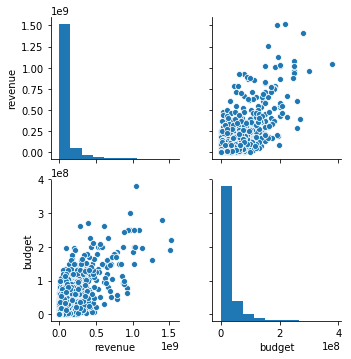

In [32]:
sns.pairplot(train[['revenue','budget']])
#sns.pairplot(train[['revenue','popularity']])

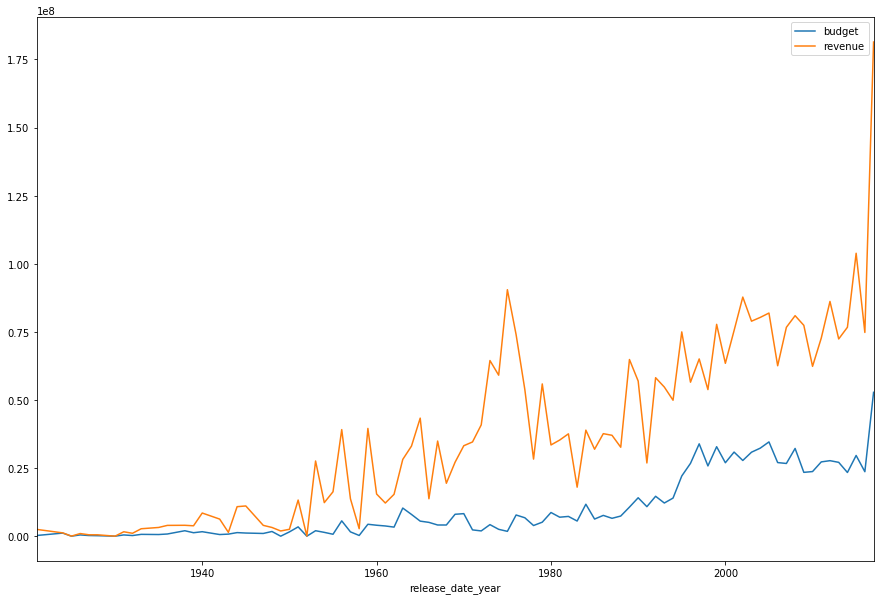

In [76]:
train['budget'].describe()
train[['release_date_year','budget','revenue']].groupby('release_date_year').mean().plot(figsize=(15,10))

Due to the vast variation in budget, the budget amount might be potentially skewed. And the log value seems to be better bell curve. so we will end up using that.

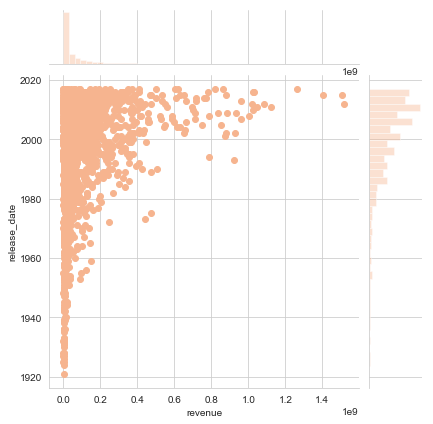

In [77]:
sns.set_style("whitegrid")
sns.set_palette("rocket_r")
sns.jointplot(train['revenue'],pd.to_datetime(train['release_date']).dt.year)

Another aspect we have to keep in mind is that the bugdet really relative to the release year. What this means is, in recent years more budget is getting poured into the movie business and doesn't necessary lead to the same outcome as the earlier years.

### Popularity

This feature does imply better revenue, just based on domain knowledge and intuition. Let's see if that intuition holds up by plotting revenue vs popularity. As can be seen it's not a clear cut,but it does look like even if higher popularity does not imply higher revenue, the movies with higher revenue does seem to have higher popularity.

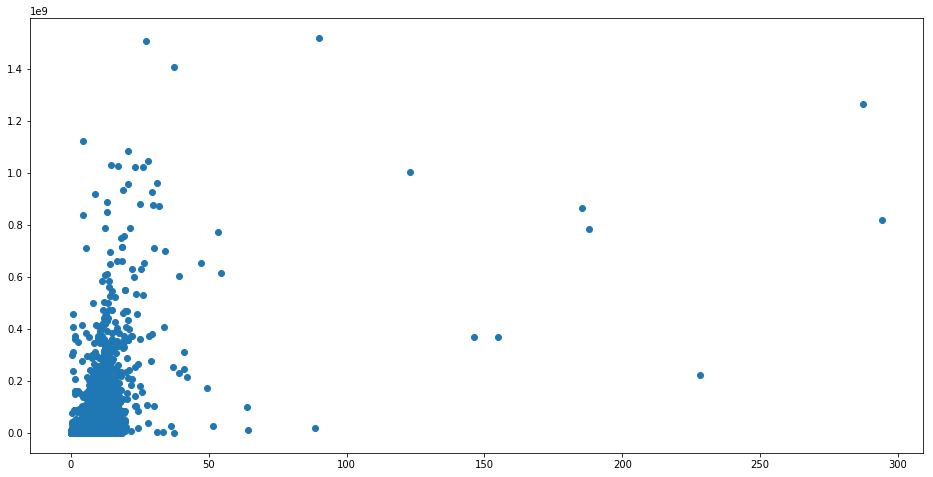

In [37]:
train['popularity'].apply(lambda x: 1 if x != {} else 0).value_counts()

plt.figure(figsize=(16,8))
plt.scatter(train['popularity'],train['revenue'])
plt.show()

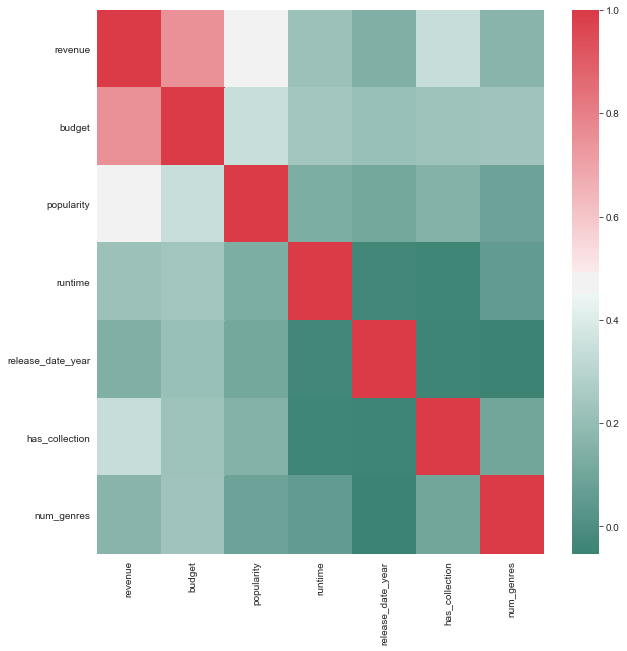

In [78]:
corr = train[['revenue','budget','popularity','runtime','release_date_year','has_collection','num_genres']].corr()
fig, ax = plt.subplots(figsize=(10,10)) 
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, cmap=sns.diverging_palette(170, 10, as_cmap=True),ax=ax)

In [41]:
train = train.drop(['production_companies', 'all_production_companies'], axis=1)
test = test.drop(['production_companies', 'all_production_companies'], axis=1)

### Status

To numerically account for all the movies that are actually released, we used the status column's released status to mark them as 1. Although the data has the same value for all the movie, it might be worth keeping the numric value

In [42]:
train['status'] = train['status'].apply(lambda x: 0 if x == 'Released' else 1)
train['status'].describe()

count    3000.000000
mean        0.001333
std         0.036497
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         1.000000
Name: status, dtype: float64

### Text based features

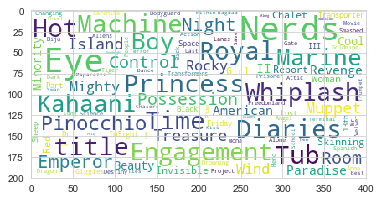

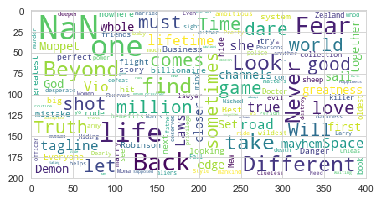

In [81]:
from subprocess import check_output
from wordcloud import WordCloud, STOPWORDS

stopwords = set(STOPWORDS)
wordcloud = WordCloud(
                          background_color='white',
                          stopwords=stopwords,
                          max_words=200,
                          max_font_size=40, 
                          random_state=42
                         ).generate(str(train[['title']]))
fig = plt.figure(1)
plt.imshow(wordcloud)
plt.show()

wordcloud = WordCloud(
                          background_color='white',
                          stopwords=stopwords,
                          max_words=200,
                          max_font_size=40, 
                          random_state=42
                         ).generate(str(train[['tagline']]))
fig = plt.figure(1)
plt.imshow(wordcloud)
plt.show()


### Unused Features

Not all of the data in dataset is usable. Or at least in the form it is in for our predictions. So ended up removing the columns homepage, imbd_id and the poster_path.

In [44]:
train.columns[:30]

Index(['id', 'budget', 'homepage', 'imdb_id', 'original_title', 'overview',
       'popularity', 'poster_path', 'production_countries', 'release_date',
       'runtime', 'spoken_languages', 'status', 'tagline', 'title', 'Keywords',
       'cast', 'crew', 'revenue', 'collection_name', 'has_collection',
       'num_genres', 'genre_History', 'genre_Foreign', 'genre_Science Fiction',
       'genre_Fantasy', 'genre_Action', 'genre_War', 'genre_Comedy',
       'genre_Documentary'],
      dtype='object')

### Production Country

In [45]:
print(train['production_countries'][0])

train['num_production_countries'] = train['production_countries'].apply(lambda x: len(x) if x != {} else 0)
train['all_production_countries'] = train['production_countries'].apply(lambda x: ' '.join(sorted([i['name'] for i in x])) if x != {} else '')
top_companies = [m[0] for m in Counter([i for j in list_of_companies for i in j]).most_common(30)]
for g in top_companies:
    train['production_countries_' + g] = train['all_production_countries'].apply(lambda x: 1 if g in x else 0)
    
test['num_production_countries'] = test['production_countries'].apply(lambda x: len(x) if x != {} else 0)
test['all_production_countries'] = test['production_countries'].apply(lambda x: ' '.join(sorted([i['name'] for i in x])) if x != {} else '')
for g in top_companies:
    test['production_countries_' + g] = test['all_production_countries'].apply(lambda x: 1 if g in x else 0)
    
#train = train.drop(['production_countries', 'all_production_countries'], axis=1)
#test = test.drop(['production_countries', 'all_production_countries'], axis=1)

[{'iso_3166_1': 'US', 'name': 'United States of America'}]


## Feature Engineering

Another intuition from our domain knowledge is the fact that who is in the movie as well who made the movie really help the population in deciding wheather to watch it or not. Although we had the information about the crew and the director who made the movie, the dataset lacks a numberical information on how each compare from one another, just based on their popularity.

So for those information we scrapped this information from rotten tomatoes for each director and for the first five cast members of each movie

### Rotten tomatoes
we used simple average calculation, to determine cast and director score from rotten tomatoes. the code for scraping can be found at scrape_cast.ipynb and scrape_director_score.ipynb in this repository.

In [46]:
director_score_train = pd.read_csv('director')
director_score_test = pd.read_csv('director_test')

In [47]:
director_score_test['id'] = director_score_test['id'].apply(lambda x : x + 3000)
director_score_test.shape

(4398, 2)

In [48]:
train_result = pd.merge(train, director_score_train, on='id')
test_result = pd.merge(test, director_score_test, on= 'id')

In [49]:
cast_score_train = pd.read_csv('cast')

In [50]:
train_result_director_cast = pd.merge(train_result, cast_score_train, on='id')

In [51]:
cast_score_test = pd.read_csv('cast_test')

In [52]:
cast_score_test['id'] = cast_score_test['id'].apply(lambda x : x + 3000)
test_result_director_cast = pd.merge(test_result, cast_score_test, on='id')

Chart below show correltion of the scores of cast members and directs against the movie revenue.

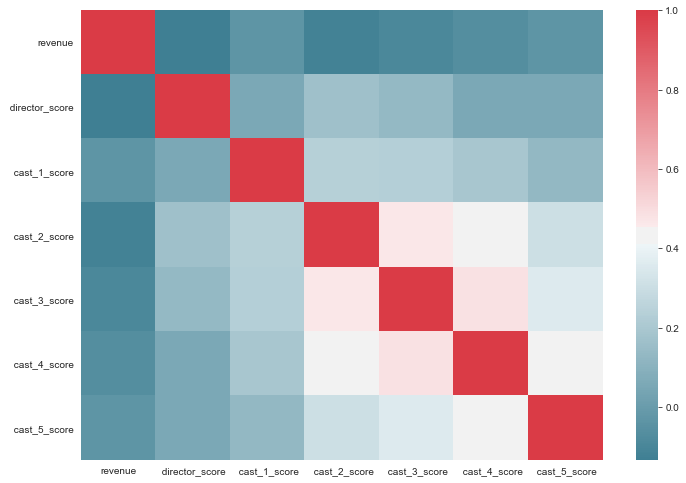

In [79]:
#train_result_director_cast.describe()
plt.gcf().set_size_inches(11.7, 8.27)
corr = train_result_director_cast[['revenue',' director_score',' cast_1_score',' cast_2_score',' cast_3_score',' cast_4_score',' cast_5_score']].corr()
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, cmap=sns.diverging_palette(220, 10, as_cmap=True))

### Feature Importance

Let's evaluate feature importance for all the features we have assembled so far.

In [53]:
from sklearn.ensemble import RandomForestClassifier

X = train_result_director_cast
X_test = test_result_director_cast
y =  np.log1p(train['revenue'])

X = X.drop(['original_title', 'overview', 'homepage', 'imdb_id', 
            'production_countries', 'status',
            'spoken_languages', 'title', 'Keywords', 'poster_path',
            'tagline', 'cast', 'crew', 'collection_name',
            'revenue', 'spoken_languages_', 'id','release_date', 
            'all_production_countries', 'log_revenue'], axis = 1)

X_test = X_test.drop(['original_title', 'overview', 'homepage', 'imdb_id', 
            'production_countries', 'status',
            'spoken_languages', 'title', 'Keywords', 'poster_path',
            'tagline', 'cast', 'crew', 'collection_name',
            'spoken_languages_', 'id','release_date', 
            'all_production_countries'], axis = 1)

In [54]:
X = X.replace([np.inf, -np.inf], 0)
X = X.fillna(value = 0)
## from sklearn.ensemble import RandomForestClassifier
rf_model = RandomForestRegressor(bootstrap = True)

parameters = {
    'max_depth':[40,], 
    'max_features' : [80],
    'n_estimators':[300]
}
clf = GridSearchCV(rf_model, parameters, cv=5, n_jobs=6, scoring = 'neg_mean_squared_log_error')
clf.fit(X, y)
clf.best_params_

{'max_depth': 40, 'max_features': 80, 'n_estimators': 300}

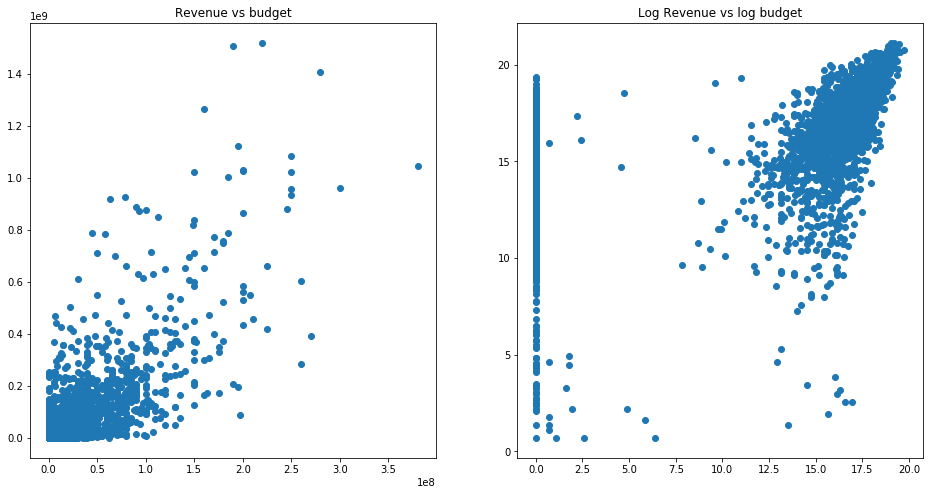

In [56]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.scatter(train['budget'], train['revenue'])
plt.title('Revenue vs budget');
plt.subplot(1, 2, 2)
plt.scatter(np.log1p(train['budget']), np.log1p(train['revenue']))
plt.title('Log Revenue vs log budget');

In [57]:
rf_model = RandomForestRegressor(bootstrap = True, max_depth = 40, max_features = 80, n_estimators = 300)
rf_model.fit(X, y)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=40,
           max_features=80, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=300, n_jobs=None, oob_score=False,
           random_state=None, verbose=0, warm_start=False)

In [58]:
importances = rf_model.feature_importances_
indices = np.argsort(importances)[::-1]
cols = list(X)
selected_columns = []
print(X.shape)
for i in range(0, 60):
    print(str(cols[indices[i]]) + ":" + str(importances[indices[i]]))
    selected_columns.append(cols[indices[i]])


(3000, 191)
budget:0.27549246019938595
popularity:0.17915186966760613
release_date_year:0.06263476063610773
runtime:0.044149353458593575
 cast_2_score:0.03795678096145177
 director_score:0.037950204558351346
 cast_3_score:0.03384881417816727
 cast_1_score:0.029287141374224633
release_date_weekofyear:0.026863225228974594
num_companies:0.026135186929253207
release_date_day:0.025766708276669062
 cast_4_score:0.02405941900875168
 cast_5_score:0.021446135326430544
has_collection:0.01911332760986576
release_date_weekday:0.015252776460139988
release_date_month:0.013700263076738125
num_genres:0.011639242926486845
num_production_countries:0.009924475819115895
release_date_quarter:0.005559375757841958
genre_Drama:0.005048284563689139
genre_Adventure:0.004985323677004934
genre_Foreign:0.004766168970865672
genre_Thriller:0.004542824672254422
original_language_fr:0.0044943436837054295
genre_Comedy:0.004462196807193186
genre_Action:0.00444764615301444
genre_Crime:0.0040429989527399224
genre_Romance:

## Process text columns

In [59]:
train_texts = train[['title', 'tagline', 'overview', 'original_title']]
test_texts = test[['title', 'tagline', 'overview', 'original_title']]

In [60]:
import time
# function refer from: https://www.kaggle.com/artgor/eda-feature-engineering-and-model-interpretation
n_fold = 5
folds = KFold(n_splits=n_fold, shuffle=True, random_state=42)
def train_model(X, X_test, y, params=None, folds=folds, model_type='lgb', plot_feature_importance=False, model=None):

    oof = np.zeros(X.shape[0])
    prediction = np.zeros(X_test.shape[0])
    scores = []
    feature_importance = pd.DataFrame()
    for fold_n, (train_index, valid_index) in enumerate(folds.split(X)):
        print('Fold', fold_n, 'started at', time.ctime())
        if model_type == 'sklearn':
            X_train, X_valid = X[train_index], X[valid_index]
        else:
            X_train, X_valid = X.values[train_index], X.values[valid_index]
        y_train, y_valid = y[train_index], y[valid_index]

        if model_type == 'sklearn':
            model = model
            model.fit(X_train, y_train)
            y_pred_valid = model.predict(X_valid).reshape(-1,)
            score = mean_squared_error(y_valid, y_pred_valid)
            
            y_pred = model.predict(X_test)
            
        
        oof[valid_index] = y_pred_valid.reshape(-1,)
        scores.append(mean_squared_error(y_valid, y_pred_valid) ** 0.5)
        
        prediction += y_pred    
    prediction /= n_fold
    return oof, prediction

In [61]:
y = np.log1p(train['revenue'])
folds = 5

for col in train_texts.columns:
    vectorizer = TfidfVectorizer(
                sublinear_tf=True,
                analyzer='word',
                token_pattern=r'\w{1,}',
                ngram_range=(1, 2),
                min_df=10
    )
    vectorizer.fit(list(train_texts[col].fillna('')) + list(test_texts[col].fillna('')))
    train_col_text = vectorizer.transform(train_texts[col].fillna(''))
    test_col_text = vectorizer.transform(test_texts[col].fillna(''))
    model = linear_model.RidgeCV(alphas=(0.01, 0.1, 1.0, 10.0, 100.0), 
                                 scoring='neg_mean_squared_error', cv=folds)
    oof_text, prediction_text = train_model(train_col_text, test_col_text, y, 
                                            params=None, model_type='sklearn', model=model)
    
    X[col + '_oof'] = oof_text
    X_test[col + '_oof'] = prediction_text

Fold 0 started at Sat May  4 11:25:34 2019
Fold 1 started at Sat May  4 11:25:34 2019
Fold 2 started at Sat May  4 11:25:35 2019
Fold 3 started at Sat May  4 11:25:35 2019
Fold 4 started at Sat May  4 11:25:36 2019
Fold 0 started at Sat May  4 11:25:36 2019
Fold 1 started at Sat May  4 11:25:37 2019
Fold 2 started at Sat May  4 11:25:39 2019
Fold 3 started at Sat May  4 11:25:40 2019
Fold 4 started at Sat May  4 11:25:41 2019
Fold 0 started at Sat May  4 11:25:45 2019
Fold 1 started at Sat May  4 11:25:47 2019
Fold 2 started at Sat May  4 11:25:50 2019
Fold 3 started at Sat May  4 11:25:54 2019
Fold 4 started at Sat May  4 11:25:55 2019
Fold 0 started at Sat May  4 11:25:58 2019
Fold 1 started at Sat May  4 11:25:58 2019
Fold 2 started at Sat May  4 11:25:59 2019
Fold 3 started at Sat May  4 11:25:59 2019
Fold 4 started at Sat May  4 11:26:00 2019


Try to create more new features.

In [62]:
#Refer from: https://www.kaggle.com/artgor/eda-feature-engineering-and-model-interpretation
def new_features(df):
    df['budget_to_popularity'] = df['budget'] / df['popularity']
    df['budget_to_runtime'] = df['budget'] / df['runtime']
    
    df['_budget_year_ratio'] = df['budget'] / (df['release_date_year'] * df['release_date_year'])
    df['_releaseYear_popularity_ratio'] = df['release_date_year'] / df['popularity']
    df['_releaseYear_popularity_ratio2'] = df['popularity'] / df['release_date_year']
    
    df['runtime_to_mean_year'] = df['runtime'] / df.groupby("release_date_year")["runtime"].transform('mean')
    df['popularity_to_mean_year'] = df['popularity'] / df.groupby("release_date_year")["popularity"].transform('mean')
    df['budget_to_mean_year'] = df['budget'] / df.groupby("release_date_year")["budget"].transform('mean')
        
    return df
X = new_features(X)
X_test = new_features(X_test)

In [63]:
X = X.replace([np.inf, -np.inf], 0)
X = X.fillna(value = 0)

X_test = X_test.replace([np.inf, -np.inf], 0)
X_test = X_test.fillna(value = 0)

rf_model = RandomForestRegressor(bootstrap = True)

parameters = {
    'max_depth':[30], 
    'max_features' : [80],
    'n_estimators':[400]
}
clf = GridSearchCV(rf_model, parameters, cv=5, n_jobs=6, scoring = 'neg_mean_squared_log_error')
clf.fit(X, y)
clf.best_params_

{'max_depth': 30, 'max_features': 80, 'n_estimators': 400}

In [64]:
y_test = clf.predict(X_test)

rf_solution = pd.DataFrame({"id":test['id'], "revenue":np.expm1(y_test)})
rf_solution.to_csv("random_forest.csv", index = False)
rf_model = RandomForestRegressor(bootstrap = True, max_depth = 40, max_features = 130, n_estimators = 280)
rf_model.fit(X, y)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=40,
           max_features=130, max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=280, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [65]:
from sklearn.metrics import mean_squared_log_error
y_train_pred_rf = clf.predict(X)
msle = mean_squared_log_error(train['revenue'], np.expm1(y_train_pred_rf))
msle ** (1/2)

0.7870447479351419

In [66]:
importances = rf_model.feature_importances_
indices = np.argsort(importances)[::-1]
cols = list(X)
selected_columns = []
print(X.shape)
for i in range(0, 50):
    print(str(cols[indices[i]]) + ":" + str(importances[indices[i]]))
    selected_columns.append(cols[indices[i]])

(3000, 203)
_budget_year_ratio:0.1717171622894203
budget_to_mean_year:0.08712974518659973
popularity_to_mean_year:0.07621789658146366
budget_to_runtime:0.06773828749502443
budget:0.061559323361754674
release_date_year:0.05183692331260357
_releaseYear_popularity_ratio:0.03154963448039178
_releaseYear_popularity_ratio2:0.02956349820157381
 director_score:0.0255536347288571
popularity:0.024994163015004553
overview_oof:0.023797089266156635
runtime_to_mean_year:0.023378178662396398
runtime:0.021729331348450166
 cast_3_score:0.021398349007350954
title_oof:0.020585027709728518
tagline_oof:0.01998667183417472
 cast_2_score:0.01986364854683751
 cast_1_score:0.018164167490075194
release_date_weekofyear:0.017996743655798
release_date_day:0.017005878206662724
 cast_4_score:0.014703435848398628
original_title_oof:0.014218343306385653
 cast_5_score:0.0122297453255643
budget_to_popularity:0.01185657276389275
num_companies:0.009551455927235192
release_date_weekday:0.009111132012041325
has_collection:0

In [67]:
model_xgb = xgb.XGBRegressor()
parameters = {
    'max_depth':[4],
    'objective':['reg:linear'],
    'eta':[0.1],
    'n_estimators':[200],
    'booster' : ['gbtree'],
    'gamma':[0, 1, 10],
    'reg_alpha' : [10],
    'reg_lambda':[0]
}
clf = GridSearchCV(model_xgb, parameters, cv=5, n_jobs=6, scoring = 'neg_mean_squared_log_error')
clf.fit(X, y)
clf.best_params_

c:\users\sam.cherinet\appdata\local\programs\python\python36\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


{'booster': 'gbtree',
 'eta': 0.1,
 'gamma': 0,
 'max_depth': 4,
 'n_estimators': 200,
 'objective': 'reg:linear',
 'reg_alpha': 10,
 'reg_lambda': 0}

In [68]:
y_test = clf.predict(X_test)
y_pred = np.expm1(y_test)
solution = pd.DataFrame({"id":test['id'], "revenue":y_pred})
solution.to_csv("xgboost.csv", index = False)

In [69]:
from sklearn.metrics import mean_squared_log_error
y_train_pred = clf.predict(X)
msle = mean_squared_log_error(train['revenue'], np.expm1(y_train_pred))
msle ** (1/2)

1.3062128051347541

In [70]:
model_xgb = xgb.XGBRegressor()
parameters = {
    'max_depth':[4],
    'objective':['reg:linear'],
    'eta':[0.1],
    'n_estimators':[200],
    'booster' : ['gbtree'],
    'gamma':[1],
    'reg_alpha' : [10],
    'reg_lambda':[0,]
}
clf = GridSearchCV(model_xgb, parameters, cv=5, n_jobs=6, scoring = 'neg_mean_squared_log_error')
clf.fit(X.loc[:, selected_columns],  y)
clf.best_params_

c:\users\sam.cherinet\appdata\local\programs\python\python36\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


{'booster': 'gbtree',
 'eta': 0.1,
 'gamma': 1,
 'max_depth': 4,
 'n_estimators': 200,
 'objective': 'reg:linear',
 'reg_alpha': 10,
 'reg_lambda': 0}

In [71]:
y_test = clf.predict(X_test.loc[:, selected_columns])
y_pred = np.expm1(y_test)
solution = pd.DataFrame({"id":test['id'], "revenue":y_pred})
solution.to_csv("xgboost_selected_t80_1.csv", index = False)

In [72]:
y_train_pred_xgb = clf.predict(X.loc[:, selected_columns])
msle = mean_squared_log_error(train['revenue'], np.expm1(y_train_pred))
msle ** (1/2)

1.3062128051347541

In [73]:
from sklearn.linear_model import LinearRegression
linearReg = LinearRegression()

stack_X = pd.DataFrame({'rf':np.expm1(y_train_pred_rf), 'xgb':np.expm1(y_train_pred_xgb)})

linearReg.fit(stack_X, train['revenue'])

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [74]:
stack_X_test = pd.DataFrame({'rf': rf_solution['revenue'], 'xgb':solution['revenue']})
y_combined = linearReg.predict(stack_X_test)

In [75]:
solution_combined = pd.DataFrame({"id":test['id'], "revenue":y_combined})
solution_combined.to_csv("combined.csv", index = False)

## Results
* Our best is 2.05 which is 346 in 928 teams
* It may relate to the domain knowledge to create extra features
* IMDB (Maybe other’s model just proof that IMDB gets more accurate data)
* Movie industry
* Misleading data
* Time does matter, review score is not stable


## Future Works

* Collect more information
* Domain knowledge
* Try to filtered out the outliers
* Try to use more NLP technologies
* Maybe the review of staff and crew also related to some specific time period
* Maybe different country, get totally different patterns
* Maybe posters do made people buy tickets
* Economy -  Inflation

## Lesson Learned
* Feature Engineering is important - based on how you use them
* Domain knowledge is important - produce more meaningful features
* Try to gather more meaningful information
* Keep trying a lot and do remember to stop and thinking
